# 1. 패키지 로딩 + 데이터 가져오기

In [1]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd
from scipy import stats
import pyreadstat

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Machine Learning Libraries
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# Econometrics Libraries
import statsmodels.api as sm
from scipy.stats import norm

In [2]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 2. 최장기 일자리 일을 그만둔 이유

E2_3 최장기 일자리_일을 그만둔 이유	
- 1	정년퇴직
- 2	건강이 좋지 않아서
- 3	정리해고, 명예퇴직, 폐업, 휴업
- 4	가사 문제(육아, 가사, 간병 등)
- 5	근로 조건 및 환경이 나빠서
- 6	이직, 창업
- 7	일할 필요가 없어서
- 8	기타
- 9	비해당

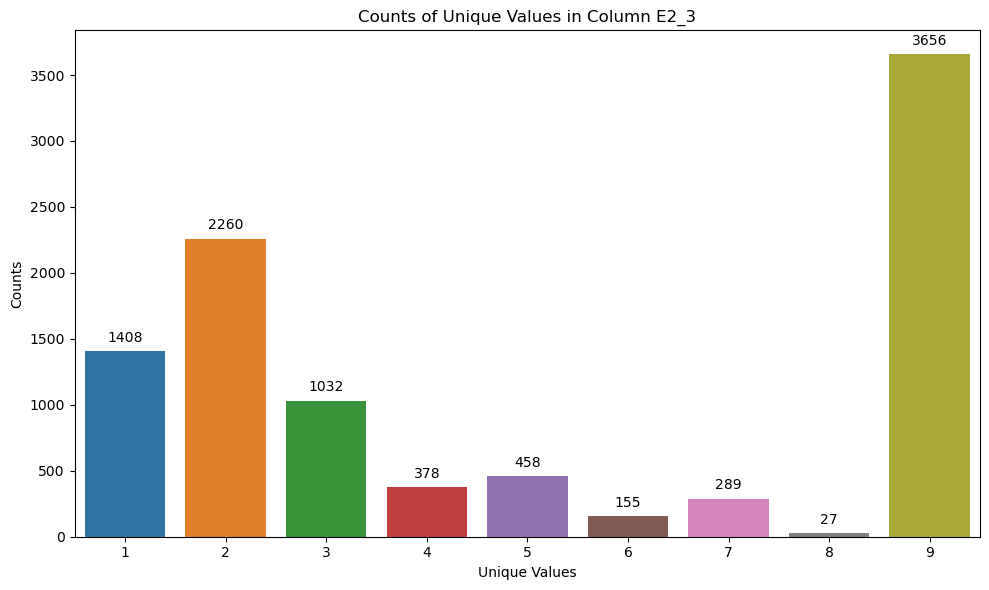

In [4]:
value_counts = df['E2_3'].value_counts()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=value_counts.index, y=value_counts.values)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100,
            '{:d}'.format(int(height)), ha='center', va='center')

plt.title('Counts of Unique Values in Column E2_3')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

정리해고, 명예퇴직, 폐업, 휴업자는 1032명으로 나타났다. 

In [5]:
df = df[df['E2_3']==3]
conditions = [
    (df['RES_AGE'] >= 63) & (df['RES_AGE'] <= 72),
    (df['RES_AGE'] >= 73) & (df['RES_AGE'] <= 82),
    (df['RES_AGE'] >= 83) & (df['RES_AGE'] <= 92)
]
values = ["forty", "fifty", "sixty"]
df['treatment'] = np.select(conditions, values, default="rest")
df = df[df['treatment'] != "rest"]

# 4. Linear regressions

X:
- 건강: B1 (1->5 안 좋아짐)*(비해당:9)*
- 성별: RES_SEX <남자: 1, 여자: 2> -> categorical
- 교육수준: RES_EDU1 <1->7 높아짐>
-  지역 (광역시/도): AREA -> categortical
    - <11:서울 21:부산 22:대구 23:인천 24:광주 25:대전 26:울산 29:세종 31:경기 32:강원 33:충북 34:충남 35:전북 36:전남 37:경북 38:경남 39:제주>
- 지역: EDM 동부/읍면부 (1:동부 0:읍면부)
- 본인 총수입액 금액: J3b_1_13 
- 나이: RES_AGE
- 인지기능: I1x1 *(결측치:99)*

Y:
- 부동산자산비중: property_equity_ratio
- 금융자산비중: financial_equity_ratio
- 문화여가비비중: leisure_expense_ratio (월평균 여가비 소비/월평균 소비지출액)
- 우울증척도총점: B6_SUM
- 만족도_경제상태: H16_2 (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)
- 만족도_삶 전반: H16_7  (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)

In [6]:
AREAs = [11,21,22,23,24,25,26,29,31,32,33,34,35,36,37,38,39]
# 지역 값 바꿔주기
df['AREA'] = df['AREA'].replace({11:"Seoul", 21:"Busan", 22:"Daegu", 23:"Incheon", 24:"Gwangju", 25:"Daejeon", 
         26:"Ulsan", 29:"Sejong", 31:"Gyeonggi", 32:"Gangwon",
        33:"Chungbuk", 34:"Chungnam",35:"Jeonbuk",36:"Jeonnam",
        37:"Gyeongbuk",38:"Gyeongnam", 39:"Jeju"})

# Treatment 에 대한 one-hot encoding
treatment_dummies = pd.get_dummies(df['treatment'], prefix='treatment')
treatment_dummies = treatment_dummies.drop(columns=['treatment_sixty'])

# AREA에 대한 one-hot encoding
AREA_dummies = pd.get_dummies(df['AREA'], prefix='AREA')
AREA_dummies = AREA_dummies.drop(columns=['AREA_Seoul']) 

# Concatenate
treatment_columns = treatment_dummies.columns.tolist()
area_columns = AREA_dummies.columns.tolist()
df = pd.concat([df, treatment_dummies, AREA_dummies], axis=1)


X_columns = ['B1','RES_SEX','RES_EDU1','EDM','J3b_1_13','RES_AGE','I1x1'] + treatment_columns + area_columns
Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

X = df[X_columns]
X = sm.add_constant(X)

## 4.1 부동산자산 비중

property_equity_ratio
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.114
Model:                               OLS   Adj. R-squared:                  0.092
Method:                    Least Squares   F-statistic:                     5.189
Date:                   Tue, 29 Aug 2023   Prob (F-statistic):           5.59e-15
Time:                           10:54:41   Log-Likelihood:                 86.312
No. Observations:                   1031   AIC:                            -120.6
Df Residuals:                       1005   BIC:                             7.771
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

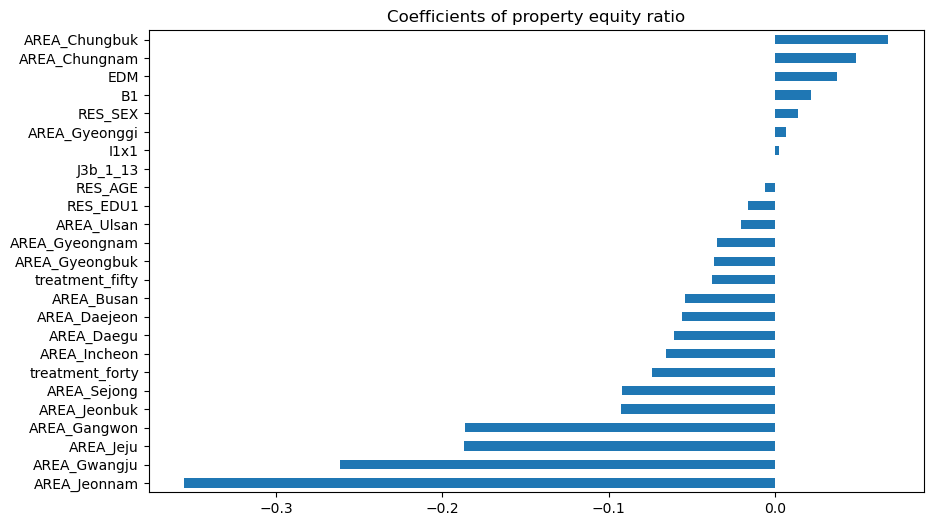

In [7]:
model = sm.OLS(df['property_equity_ratio'], X).fit()
               
print("property_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of property equity ratio")
plt.show()

|column|coefficient|p value|
|--|--|--|
|RES_AGE| -0.0057 |0.061|
|treatment_forty|-0.0378|0.192|
|treatment_fifty|-0.0737|0.292|
    
나이가 오름에 따라 부동산자산비중이 줄어들지만, 40/50 그룹의 부동산자산비중이 더 낮음. p값이 다소 높지만, 어쩌면 단서가 될지도. 

## 4.2 금융자산 비중

financial_equity_ratio
                              OLS Regression Results                              
Dep. Variable:     financial_equity_ratio   R-squared:                       0.104
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     4.688
Date:                    Tue, 29 Aug 2023   Prob (F-statistic):           5.34e-13
Time:                            10:54:41   Log-Likelihood:                 203.99
No. Observations:                    1031   AIC:                            -356.0
Df Residuals:                        1005   BIC:                            -227.6
Df Model:                              25                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

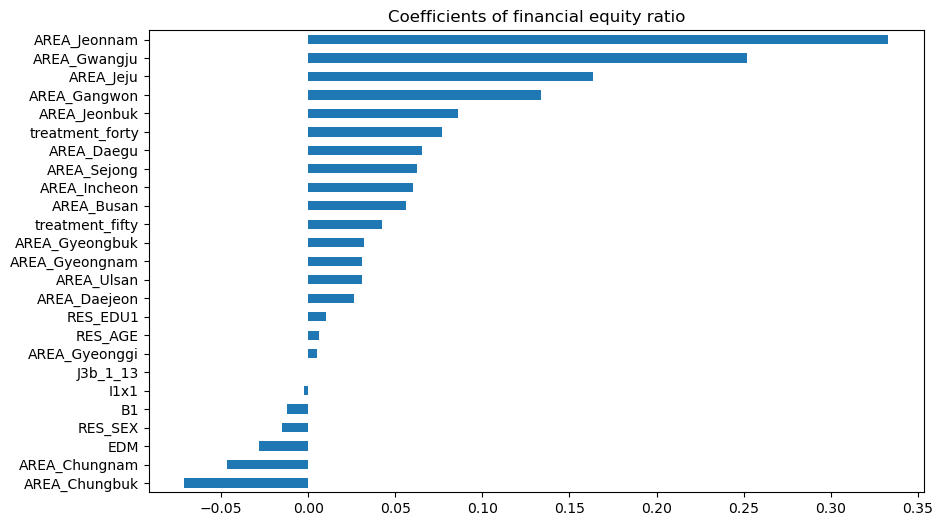

In [8]:
model = sm.OLS(df['financial_equity_ratio'], X).fit()
               
print("financial_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of financial equity ratio")
plt.show()

|column|coefficient|p value|
|--|--|--|
|RES_AGE| 0.0062 |0.023|
|treatment_forty|0.0768|0.127|
|treatment_fifty|0.0425|0.184|
    
나이가 오름에 따라 금융자산비중이 늘어나지만, 40/50 그룹의 금융자산비중이 더 높음 



## 4.3 문화여가비 비중

leisure_expense_ratio
                              OLS Regression Results                             
Dep. Variable:     leisure_expense_ratio   R-squared:                       0.184
Model:                               OLS   Adj. R-squared:                  0.164
Method:                    Least Squares   F-statistic:                     9.057
Date:                   Tue, 29 Aug 2023   Prob (F-statistic):           1.71e-30
Time:                           10:54:41   Log-Likelihood:                 1356.9
No. Observations:                   1031   AIC:                            -2662.
Df Residuals:                       1005   BIC:                            -2533.
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

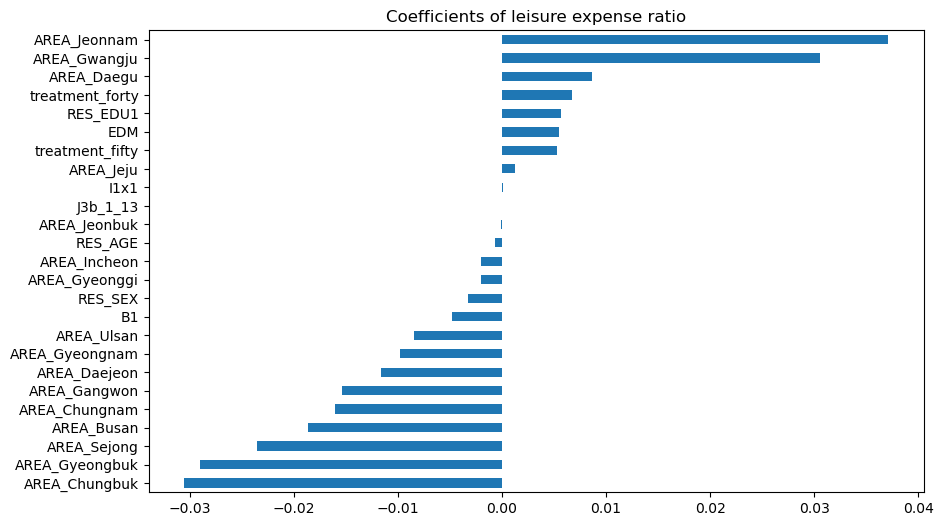

In [9]:
df['leisure_expense_ratio'] = df['J1b_3']/ df['J4']
model = sm.OLS(df['leisure_expense_ratio'], X).fit()
               
print("leisure_expense_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of leisure expense ratio")
plt.show()

## 4.4 우울증 척도 총점

Depression Score
                            OLS Regression Results                            
Dep. Variable:                 B6_SUM   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     11.34
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           1.75e-39
Time:                        10:54:41   Log-Likelihood:                -2371.8
No. Observations:                1031   AIC:                             4796.
Df Residuals:                    1005   BIC:                             4924.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.859

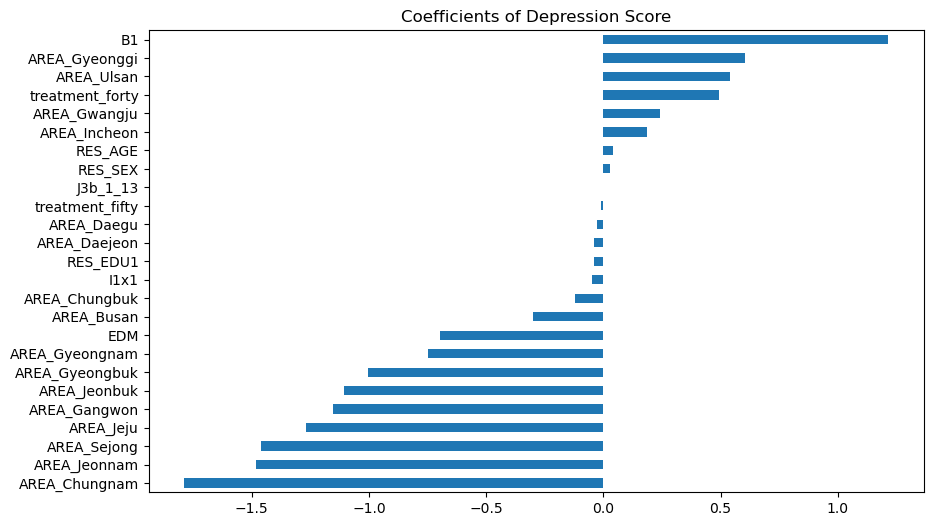

In [10]:
model = sm.OLS(df['B6_SUM'], X).fit()
               
print("Depression Score")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of Depression Score")
plt.show()

## 4.5 경제 상태 불만족도

Financial Discontent
                            OLS Regression Results                            
Dep. Variable:                  H16_2   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     11.95
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           7.38e-42
Time:                        10:54:41   Log-Likelihood:                -1232.9
No. Observations:                1031   AIC:                             2518.
Df Residuals:                    1005   BIC:                             2646.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0

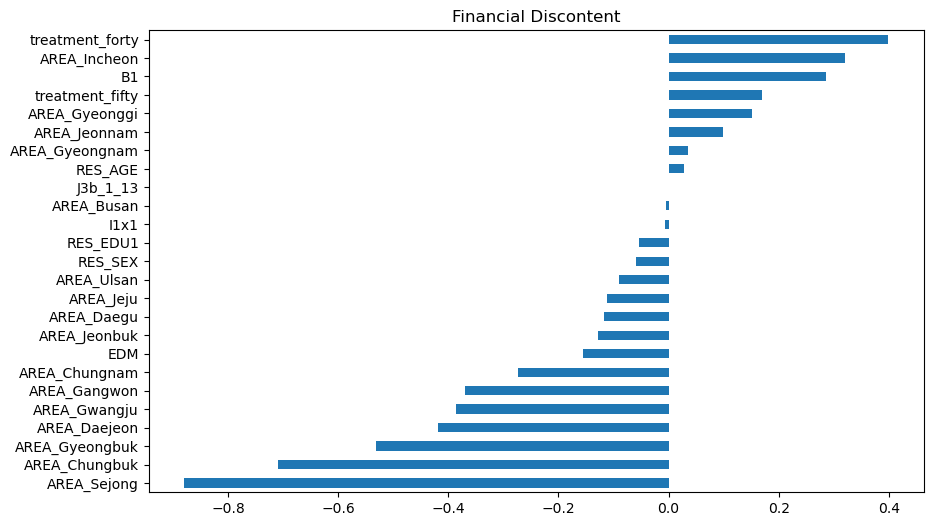

In [11]:
model = sm.OLS(df['H16_2'], X).fit()
               
print("Financial Discontent")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Financial Discontent")
plt.show()

|column|coefficient|p value|
|--|--|--|
|treatment_forty|0.3993|0.049|
|treatment_fifty|0.1694|0.189|
|RES_AGE| 0.0282 |0.011|

나이가 들수록 경제적 불만족도는 늘어났으나, 40,50의 경제적 불만족도가 높은 것으로 나옴. 꽤 유의미한 결과일지도.

정리해고자를 추려내기 전 결과는 아래와 같았음:
| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|---------------|
| treatment_forty | 0.798  | 0                  | + 0.0158      | IMF당시 근로자의 경제적 불만족도가 더 높음  |
| treatment_fifty | 0.144  | 0                  | + 0.0568      | IMF당시 근로자의 경제적 불만족도가 더 높음  |
| RES_AGE         | 0.787  | 1                  | + 0.0009      | 나이가 많을수록 경제적불만족도가 더 높음 |


## 4.6 삶 전반 불만족도

Life Discontent
                            OLS Regression Results                            
Dep. Variable:                  H16_7   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     13.42
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           1.68e-47
Time:                        10:54:42   Log-Likelihood:                -921.12
No. Observations:                1031   AIC:                             1894.
Df Residuals:                    1005   BIC:                             2023.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0186

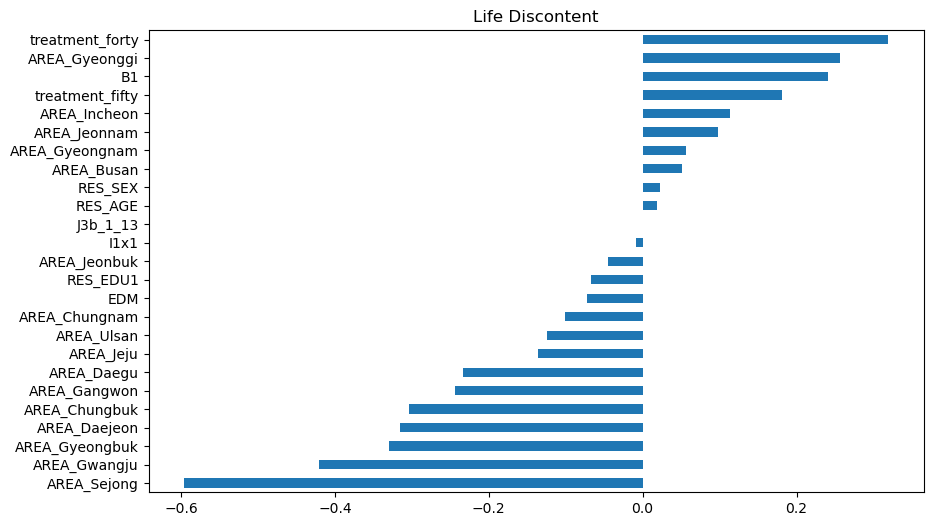

In [12]:
model = sm.OLS(df['H16_7'], X).fit()
               
print("Life Discontent")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Life Discontent")
plt.show()

|column|coefficient|p value|
|--|--|--|
|treatment_forty|0.3195|0.033|
|treatment_fifty|0.1807|0.058|
|RES_AGE| 0.0183 |0.025|

나이가 늘어남에 따라 삶에 대한 불만족도가 높아지나, 4050그룹의 삶에 대한 불만족도도 높아짐. 

정리해고자를 추려내지 않고 실시한 선형회귀 결과에 비해 p값은 낮아졌고, coefficient의 절대값은 늘어났고, 양과 음이 바뀌었습니다. 

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|---------------|
| treatment_forty | 0.495  | 0                  | - 0.0334      | IMF당시 근로자의 삶의 불만족도가 더 낮음 |
| treatment_fifty | 0.844  | 0                  | - 0.0061      | IMF당시 근로자의 삶의 불만족도가 더 낮음  |
| RES_AGE         | 0.278  | 0                  | - 0.0028      | 나이가 많을수록 삶의 불만족도가 더 낮음  |




# 5. 나이에 따른 실직사유 분석

E2_3 최장기 일자리_일을 그만둔 이유	
- 1	정년퇴직
- 2	건강이 좋지 않아서
- 3	정리해고, 명예퇴직, 폐업, 휴업
- 4	가사 문제(육아, 가사, 간병 등)
- 5	근로 조건 및 환경이 나빠서
- 6	이직, 창업
- 7	일할 필요가 없어서
- 8	기타
- 9	비해당

#### 현재 하고 있는 일이 최장기 직업이 아니거나, 일한 경험이 있으나 지금은 하지 않은 경우에만 질문하시오
    - 현재의 일이 최장기인 경우 비해당
    - 일한 경험이 없으면 비해당

## 5.1 비해당 제거 않고 분석

In [13]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)

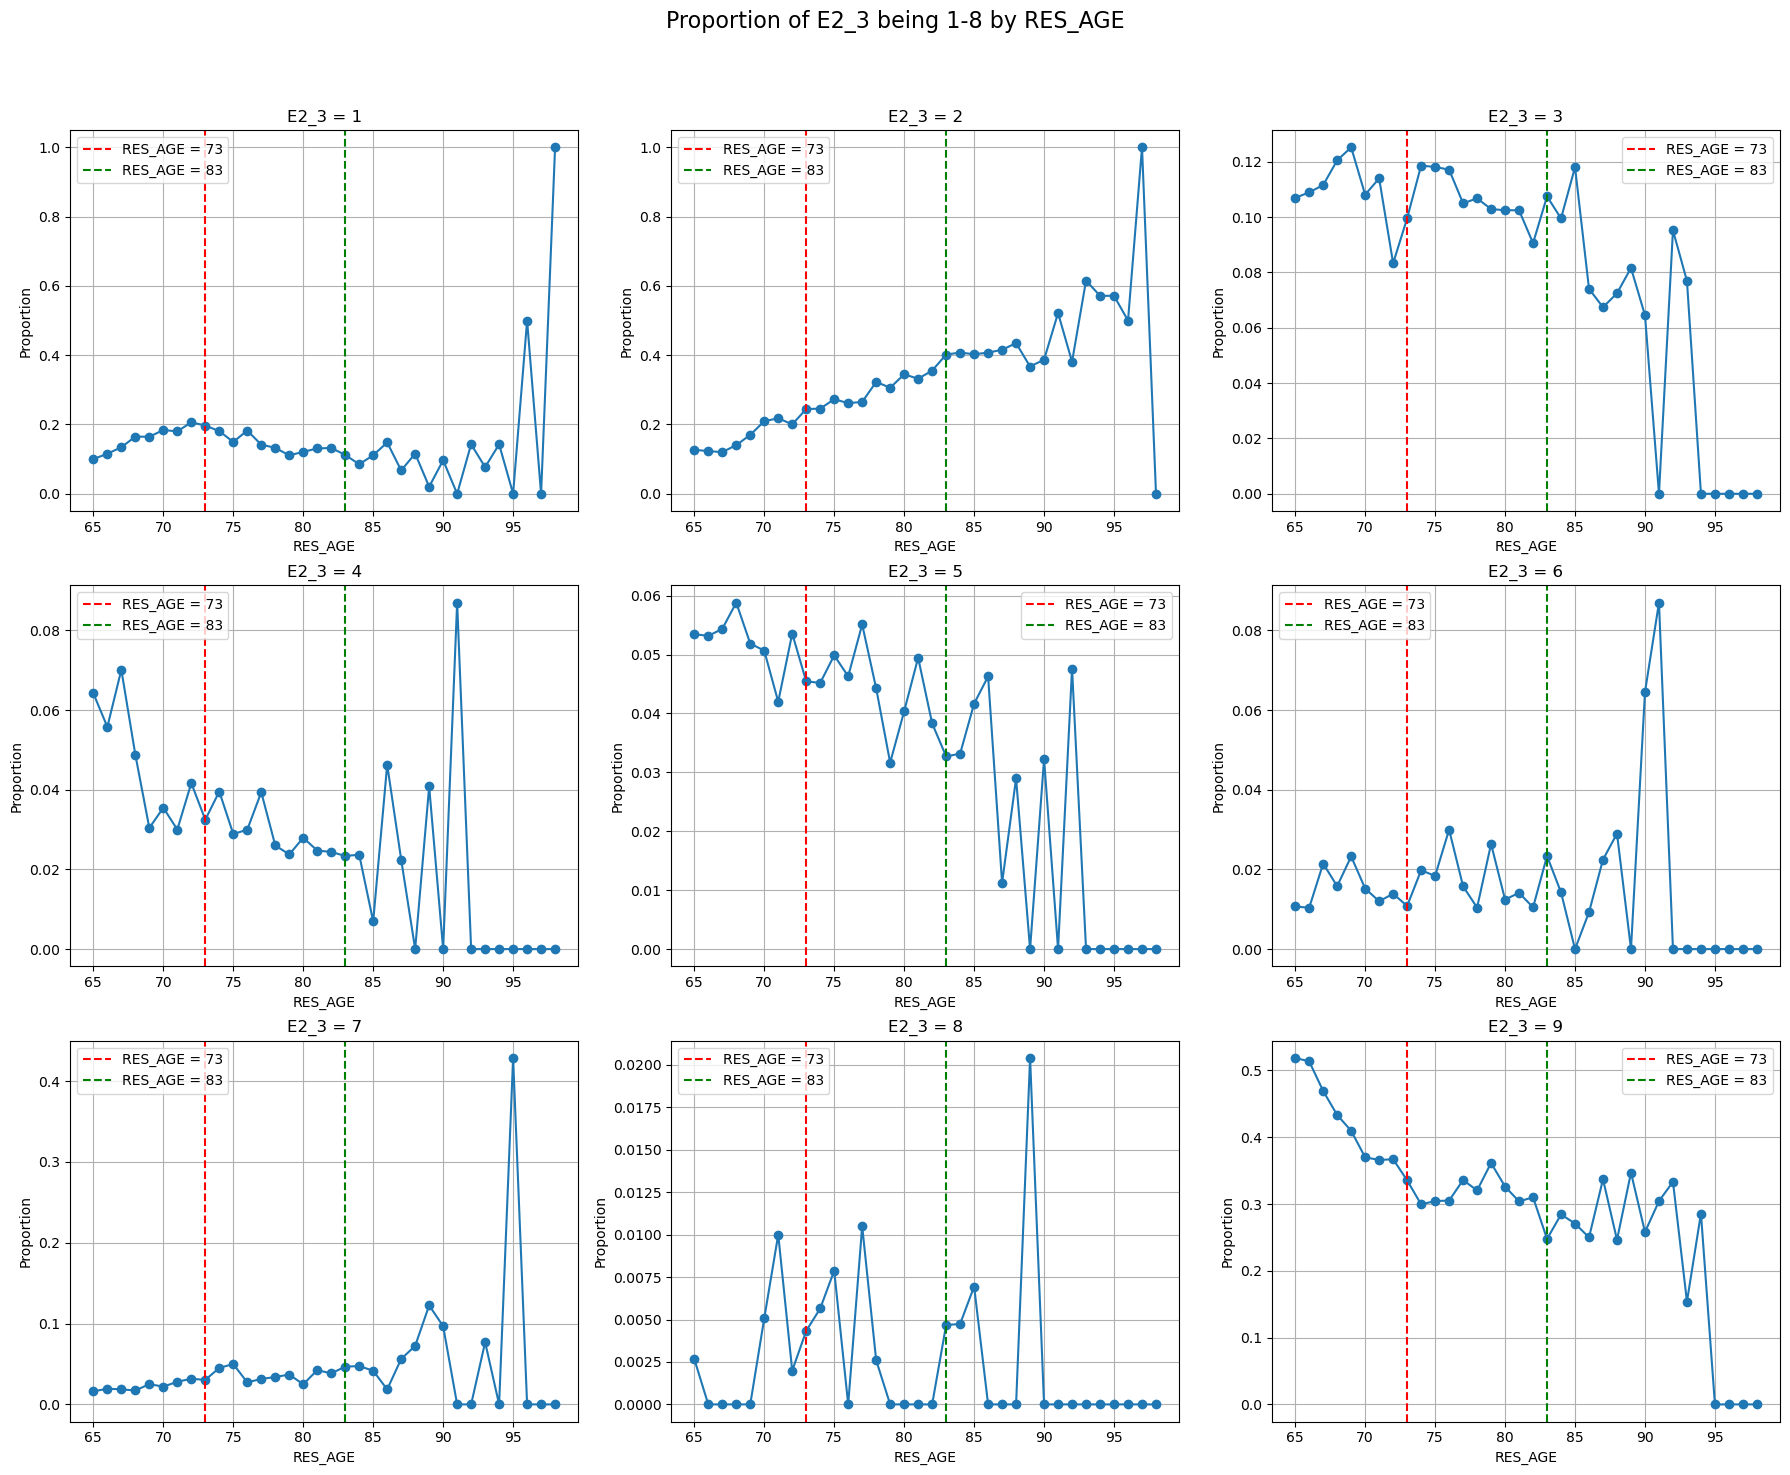

In [14]:
# Set up subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Proportion of E2_3 being 1-8 by RES_AGE', fontsize=16)

# Iterate over each value of E2_3 and plot its proportion
for idx, value in enumerate(range(1, 10)):
    ax = axes[idx//3, idx%3]  # Determine position in 2x4 grid
    
    # Group by RES_AGE and compute the proportion for the current value of E2_3
    grouped = df.groupby('RES_AGE').apply(lambda x: (x['E2_3'] == value).sum() / len(x)).reset_index()
    grouped.columns = ['RES_AGE', 'Proportion']
    
    ax.plot(grouped['RES_AGE'], grouped['Proportion'], marker='o')
    ax.axvline(x=73, color='r', linestyle='--', label='RES_AGE = 73')
    ax.axvline(x=83, color='g', linestyle='--', label='RES_AGE = 83')
    ax.set_title(f'E2_3 = {value}')
    ax.set_xlabel('RES_AGE')
    ax.set_ylabel('Proportion')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjusting so suptitle doesn't overlap
plt.show()


｜1 정년퇴직 ｜ 2 건강이 좋지 않아서 ｜ 3 정리해고, 명예퇴직, 폐업, 휴업 ｜

| 4 가사 문제(육아, 가사, 간병 등) ｜ 5 근로 조건 및 환경이 나빠서 ｜ 6 이직, 창업 ｜ 

| 7 일할 필요가 없어서 ｜ 8 기타 ｜ 9 비해당

## 5.2 비해당 제거 후 분석

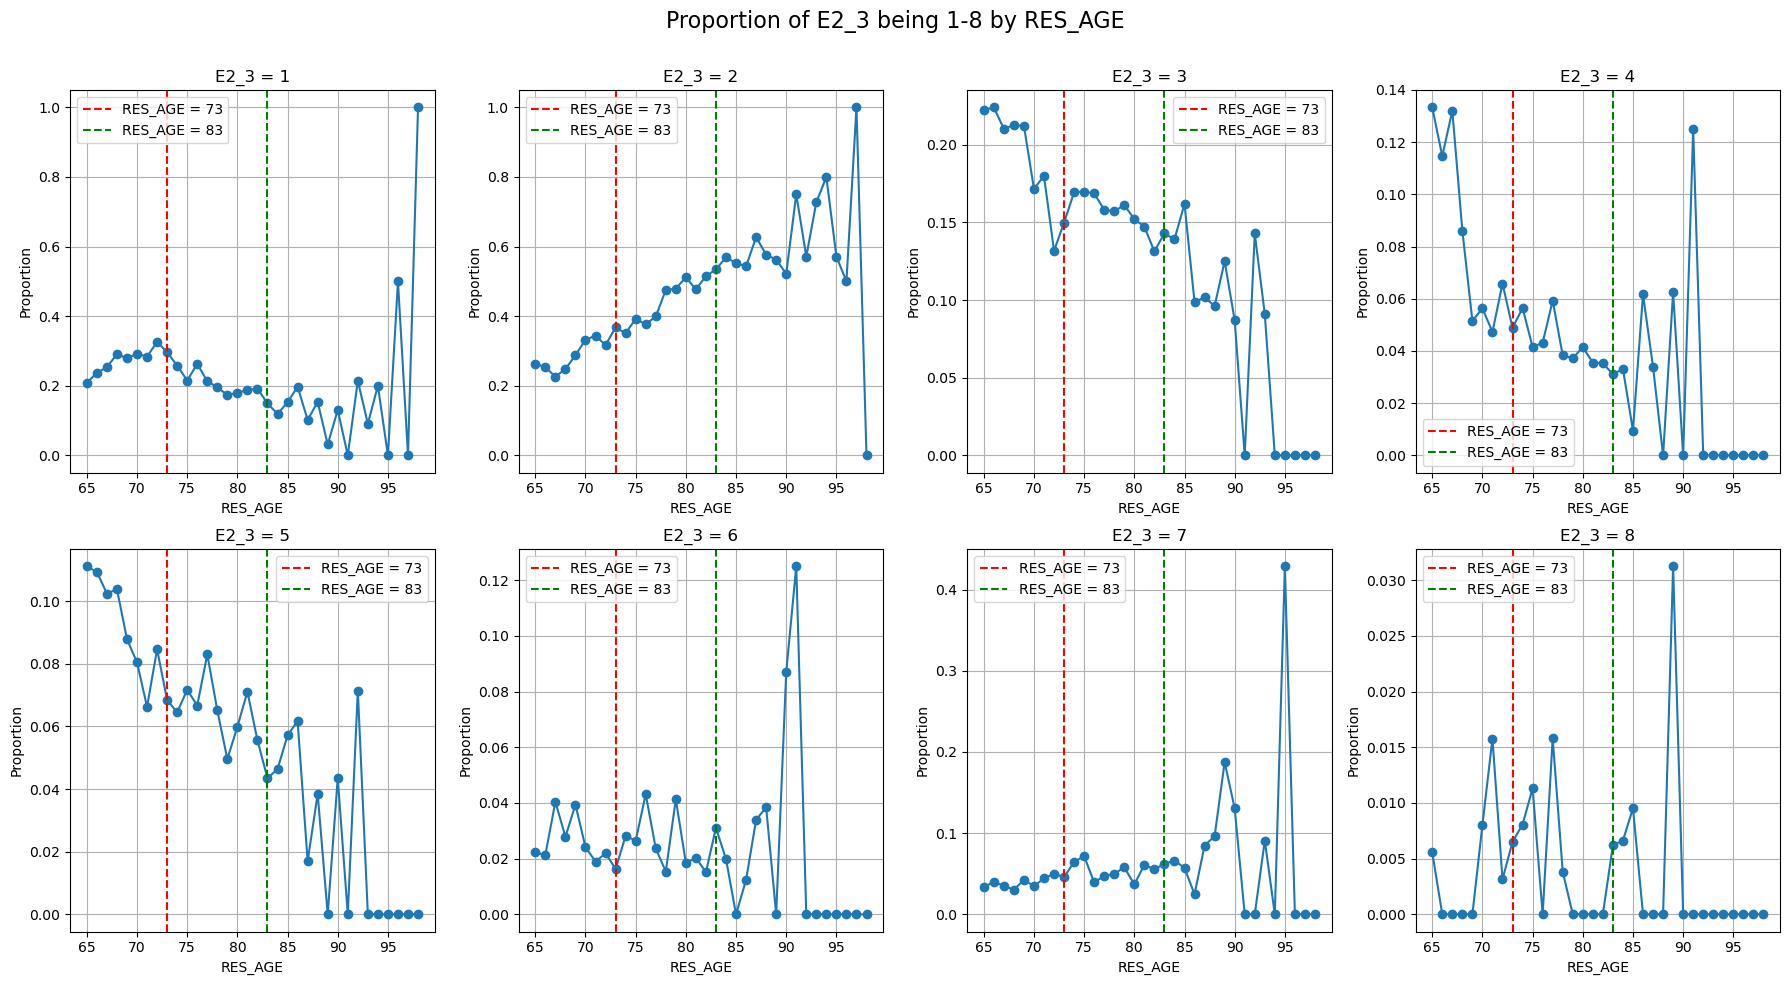

In [15]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)
df = df[df['E2_3']!=9]

# Set up subplots
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Proportion of E2_3 being 1-8 by RES_AGE', fontsize=16)

# Iterate over each value of E2_3 and plot its proportion
for idx, value in enumerate(range(1, 9)):
    ax = axes[idx//4, idx%4]  # Determine position in 2x4 grid
    
    # Group by RES_AGE and compute the proportion for the current value of E2_3
    grouped = df.groupby('RES_AGE').apply(lambda x: (x['E2_3'] == value).sum() / len(x)).reset_index()
    grouped.columns = ['RES_AGE', 'Proportion']
    
    ax.plot(grouped['RES_AGE'], grouped['Proportion'], marker='o')
    ax.axvline(x=73, color='r', linestyle='--', label='RES_AGE = 73')
    ax.axvline(x=83, color='g', linestyle='--', label='RES_AGE = 83')
    ax.set_title(f'E2_3 = {value}')
    ax.set_xlabel('RES_AGE')
    ax.set_ylabel('Proportion')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjusting so suptitle doesn't overlap
plt.show()



｜1 정년퇴직 ｜ 2 건강이 좋지 않아서 ｜ 3 정리해고, 명예퇴직, 폐업, 휴업 ｜ 4 가사 문제(육아, 가사, 간병 등) ｜

｜5 근로 조건 및 환경이 나빠서 ｜ 6 이직, 창업 ｜ 7 일할 필요가 없어서 ｜ 8 기타 ｜ 9 비해당

## 5.3 남성만 분석

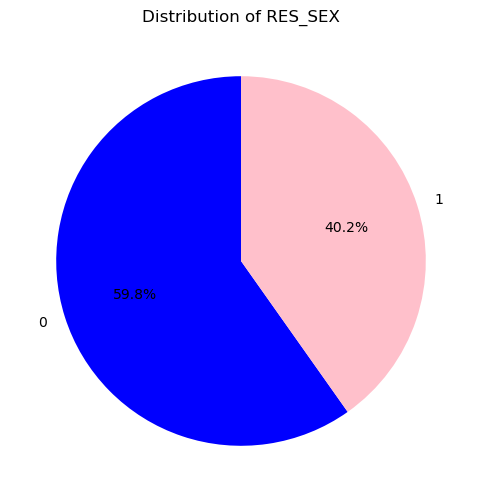

In [16]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)
sex_counts = df['RES_SEX'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 6))
sex_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['blue', 'pink', 'green'])
plt.title('Distribution of RES_SEX')
plt.ylabel('')  # This is to remove the default 'RES_SEX' y-label
plt.show()

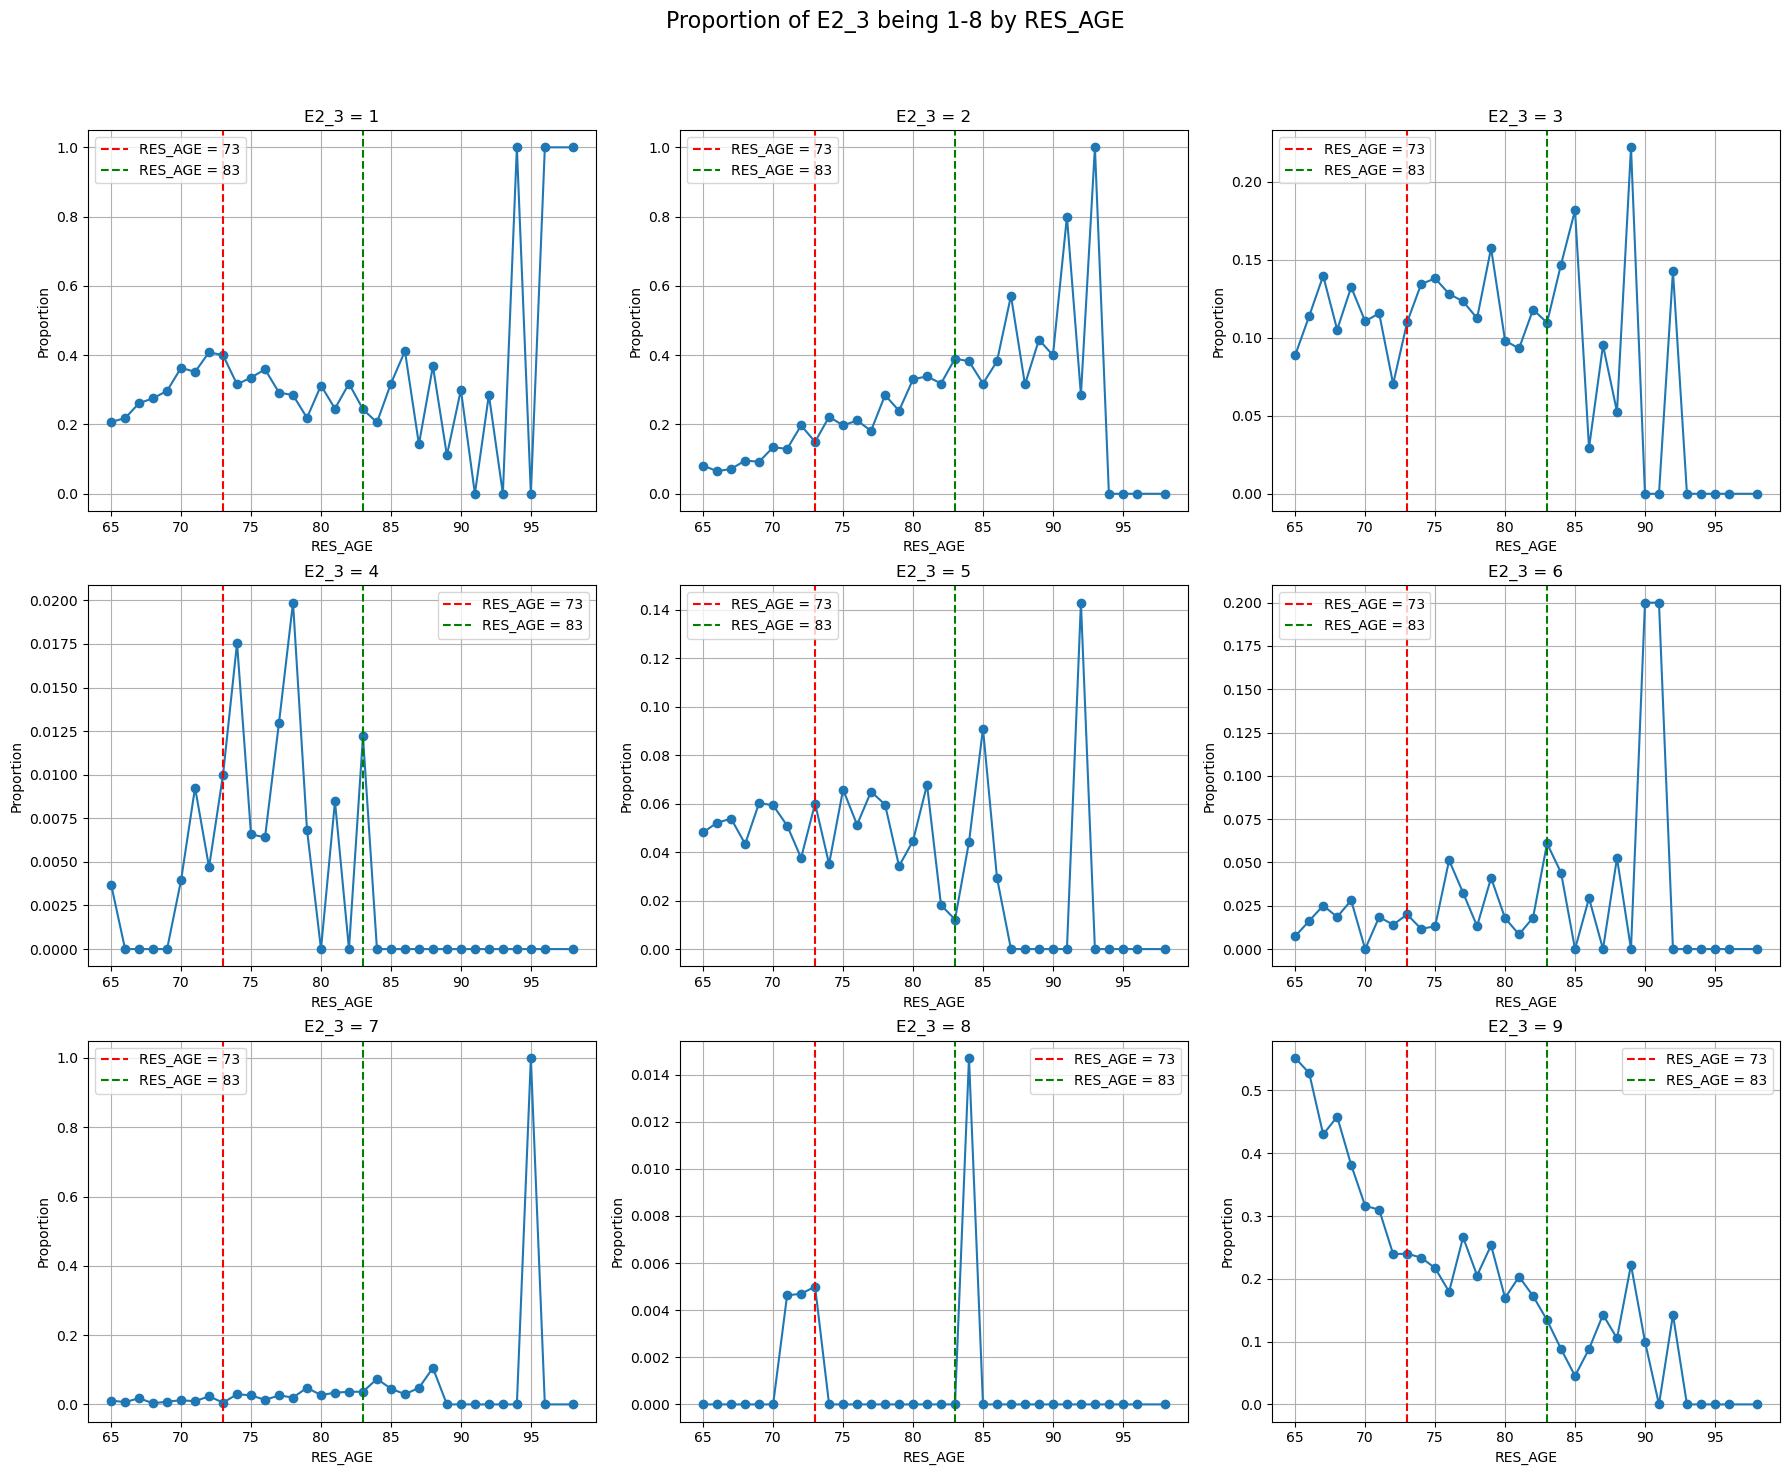

(3885, 375)


In [17]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)
df = df[df['RES_SEX'] == 1]

# Set up subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Proportion of E2_3 being 1-8 by RES_AGE', fontsize=16)

# Iterate over each value of E2_3 and plot its proportion
for idx, value in enumerate(range(1, 10)):
    ax = axes[idx//3, idx%3]  # Determine position in 2x4 grid
    
    # Group by RES_AGE and compute the proportion for the current value of E2_3
    grouped = df.groupby('RES_AGE').apply(lambda x: (x['E2_3'] == value).sum() / len(x)).reset_index()
    grouped.columns = ['RES_AGE', 'Proportion']
    
    ax.plot(grouped['RES_AGE'], grouped['Proportion'], marker='o')
    ax.axvline(x=73, color='r', linestyle='--', label='RES_AGE = 73')
    ax.axvline(x=83, color='g', linestyle='--', label='RES_AGE = 83')
    ax.set_title(f'E2_3 = {value}')
    ax.set_xlabel('RES_AGE')
    ax.set_ylabel('Proportion')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjusting so suptitle doesn't overlap
plt.show()

print(df.shape)

|1 정년퇴직 ｜ 2 건강이 좋지 않아서 ｜ 3 정리해고, 명예퇴직, 폐업, 휴업 ｜

|  4 가사 문제(육아, 가사, 간병 등) ｜ 5 근로 조건 및 환경이 나빠서 ｜ 6 이직, 창업 ｜ 

| 7 일할 필요가 없어서 ｜ 8 기타 ｜ 9 비해당

## 5.4 남성 + 비해당 제거

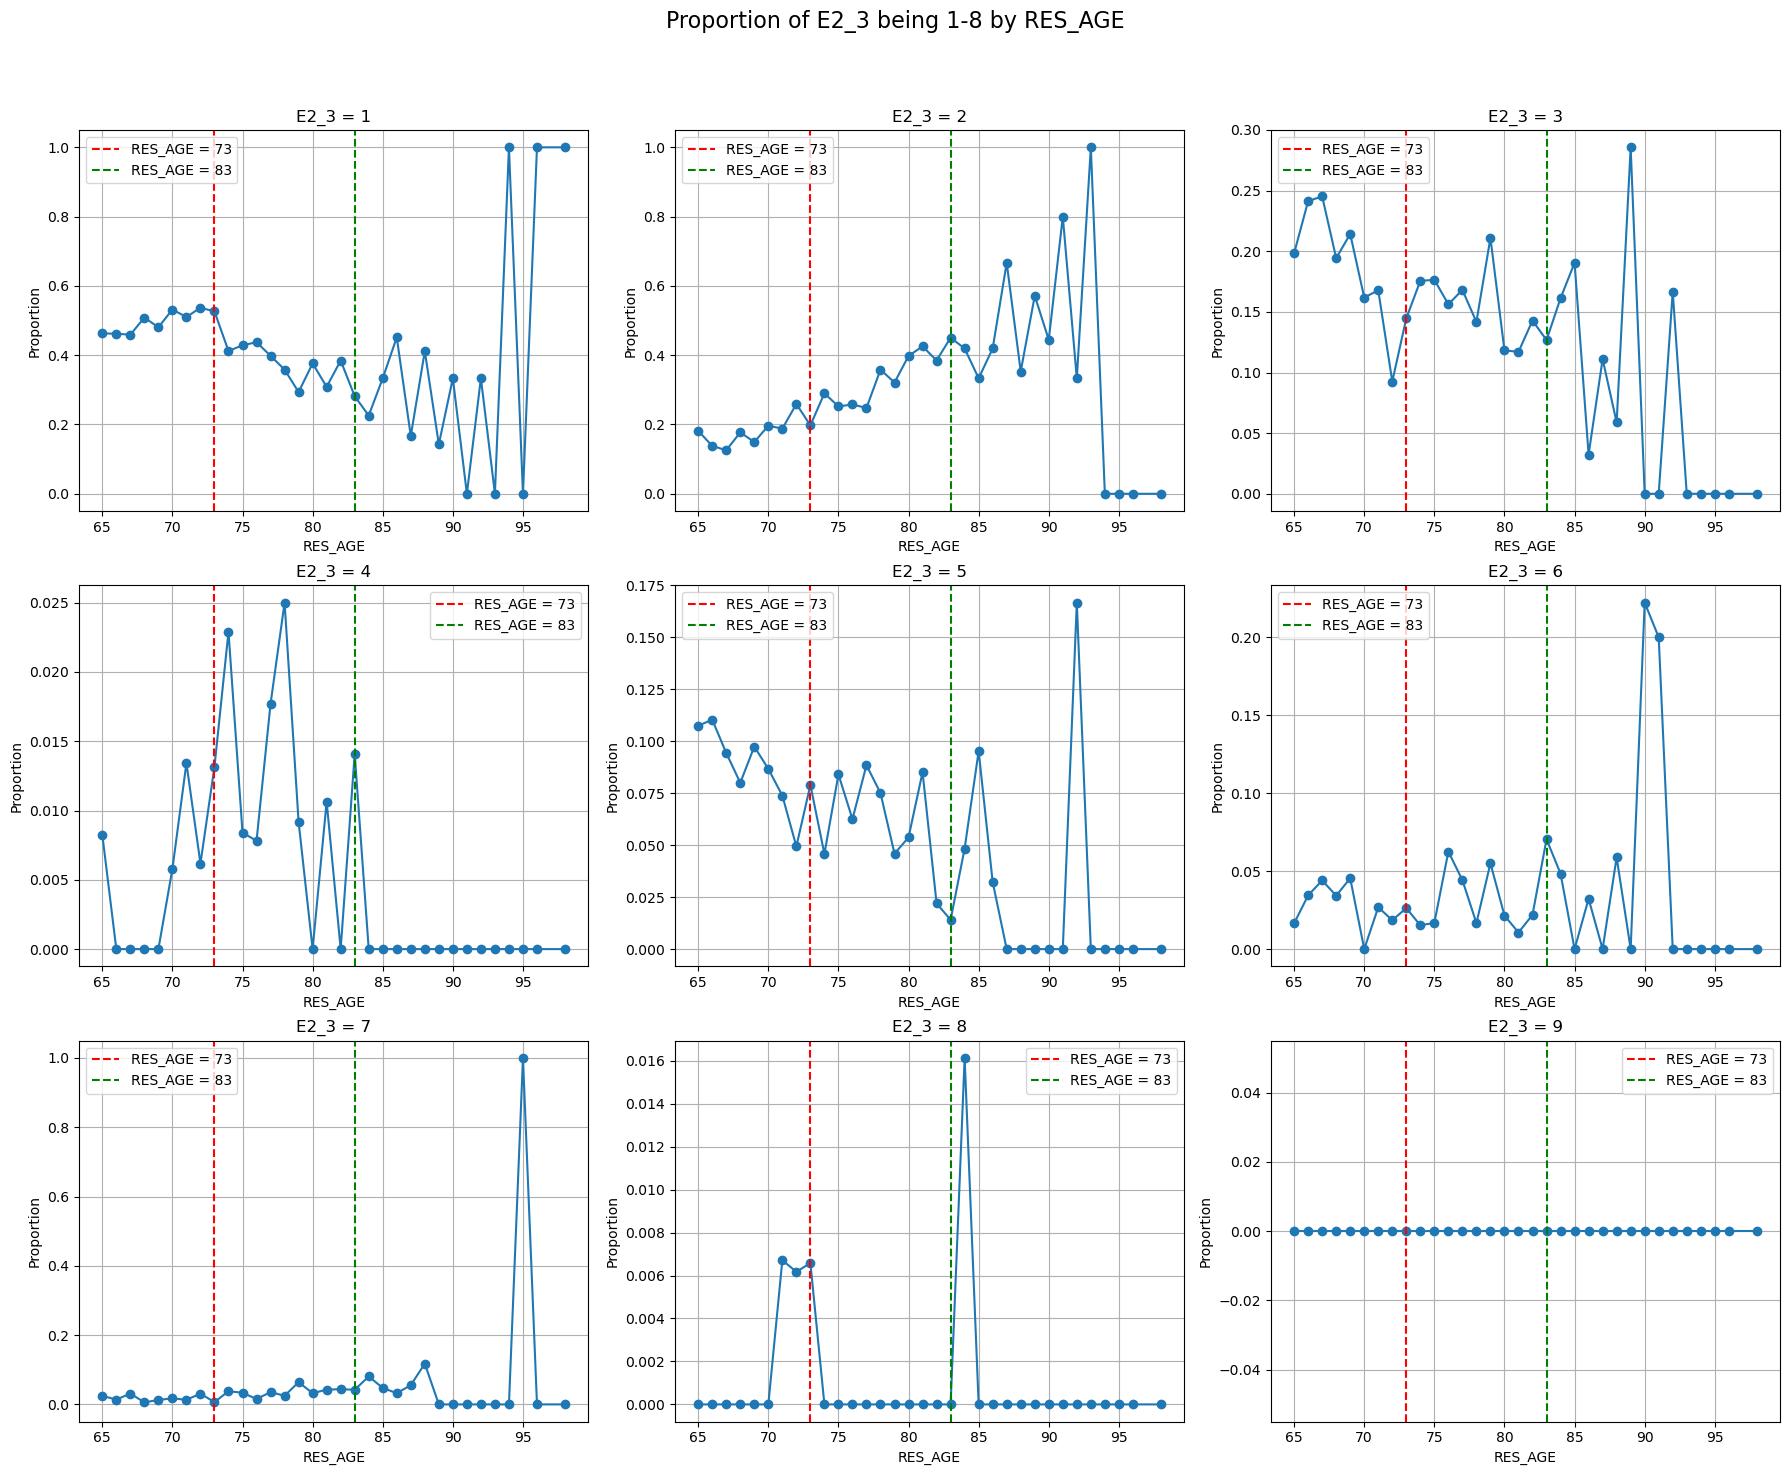

(2662, 375)


In [18]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)
df = df[df['E2_3']!=9]
df = df[df['RES_SEX'] == 1]


# Set up subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Proportion of E2_3 being 1-8 by RES_AGE', fontsize=16)

# Iterate over each value of E2_3 and plot its proportion
for idx, value in enumerate(range(1, 10)):
    ax = axes[idx//3, idx%3]  # Determine position in 2x4 grid
    
    # Group by RES_AGE and compute the proportion for the current value of E2_3
    grouped = df.groupby('RES_AGE').apply(lambda x: (x['E2_3'] == value).sum() / len(x)).reset_index()
    grouped.columns = ['RES_AGE', 'Proportion']
    
    ax.plot(grouped['RES_AGE'], grouped['Proportion'], marker='o')
    ax.axvline(x=73, color='r', linestyle='--', label='RES_AGE = 73')
    ax.axvline(x=83, color='g', linestyle='--', label='RES_AGE = 83')
    ax.set_title(f'E2_3 = {value}')
    ax.set_xlabel('RES_AGE')
    ax.set_ylabel('Proportion')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjusting so suptitle doesn't overlap
plt.show()

print(df.shape)

|1 정년퇴직 ｜ 2 건강이 좋지 않아서 ｜ 3 정리해고, 명예퇴직, 폐업, 휴업 ｜

|  4 가사 문제(육아, 가사, 간병 등) ｜ 5 근로 조건 및 환경이 나빠서 ｜ 6 이직, 창업 ｜ 

| 7 일할 필요가 없어서 ｜ 8 기타 ｜ 9 비해당

## 5.5 여성만 분석

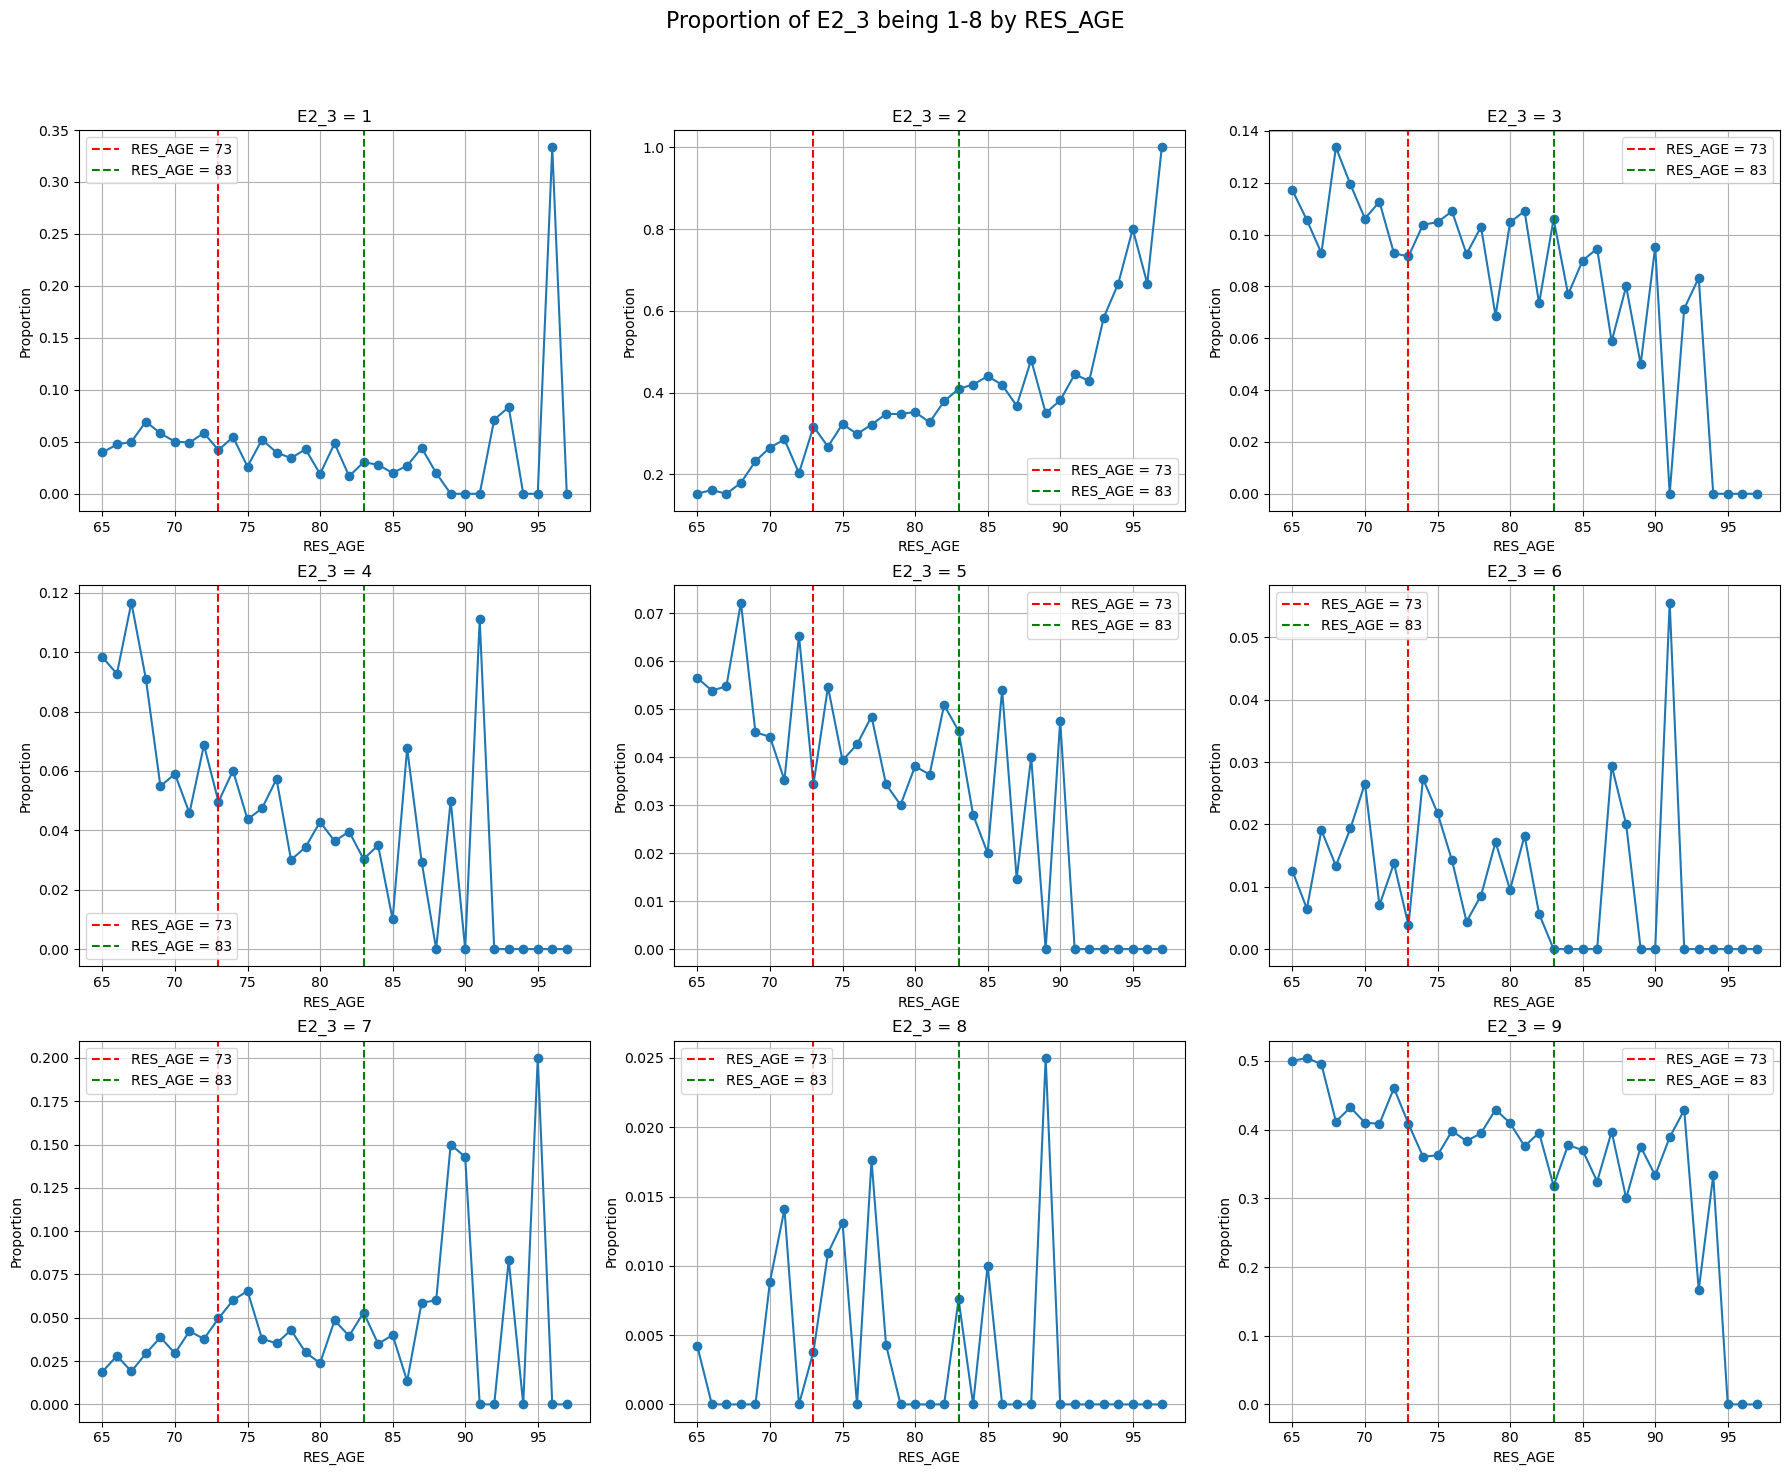

(5778, 375)


In [19]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)
df = df[df['RES_SEX'] == 0]

# Set up subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Proportion of E2_3 being 1-8 by RES_AGE', fontsize=16)

# Iterate over each value of E2_3 and plot its proportion
for idx, value in enumerate(range(1, 10)):
    ax = axes[idx//3, idx%3]  # Determine position in 2x4 grid
    
    # Group by RES_AGE and compute the proportion for the current value of E2_3
    grouped = df.groupby('RES_AGE').apply(lambda x: (x['E2_3'] == value).sum() / len(x)).reset_index()
    grouped.columns = ['RES_AGE', 'Proportion']
    
    ax.plot(grouped['RES_AGE'], grouped['Proportion'], marker='o')
    ax.axvline(x=73, color='r', linestyle='--', label='RES_AGE = 73')
    ax.axvline(x=83, color='g', linestyle='--', label='RES_AGE = 83')
    ax.set_title(f'E2_3 = {value}')
    ax.set_xlabel('RES_AGE')
    ax.set_ylabel('Proportion')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjusting so suptitle doesn't overlap
plt.show()

print(df.shape)

## 5.6 여성 + 비해당 제거

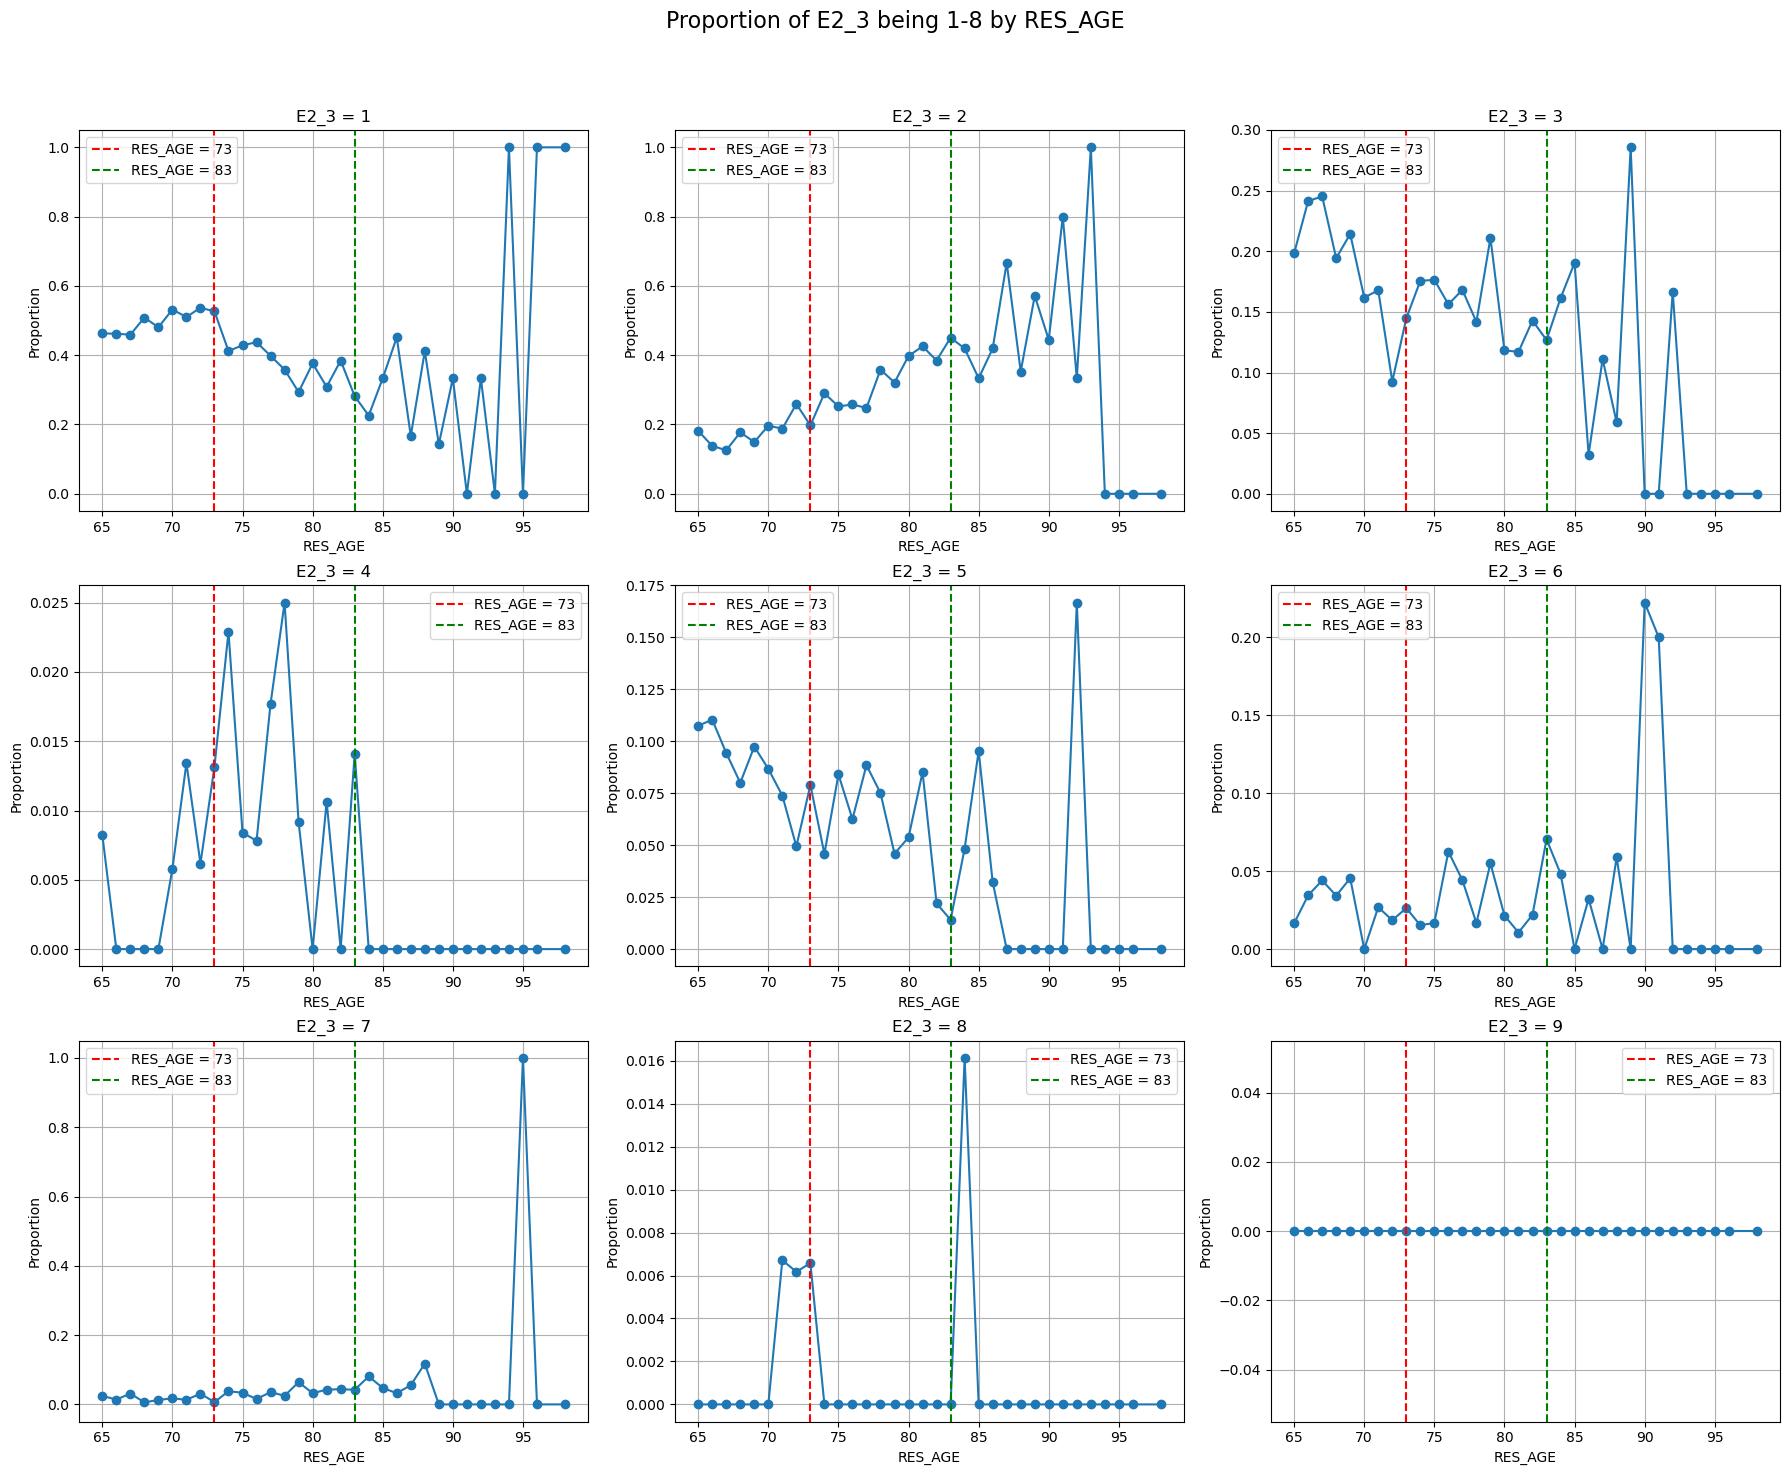

(2662, 375)


In [20]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)
df = df[df['E2_3']!=9]
df = df[df['RES_SEX'] == 1]


# Set up subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Proportion of E2_3 being 1-8 by RES_AGE', fontsize=16)

# Iterate over each value of E2_3 and plot its proportion
for idx, value in enumerate(range(1, 10)):
    ax = axes[idx//3, idx%3]  # Determine position in 2x4 grid
    
    # Group by RES_AGE and compute the proportion for the current value of E2_3
    grouped = df.groupby('RES_AGE').apply(lambda x: (x['E2_3'] == value).sum() / len(x)).reset_index()
    grouped.columns = ['RES_AGE', 'Proportion']
    
    ax.plot(grouped['RES_AGE'], grouped['Proportion'], marker='o')
    ax.axvline(x=73, color='r', linestyle='--', label='RES_AGE = 73')
    ax.axvline(x=83, color='g', linestyle='--', label='RES_AGE = 83')
    ax.set_title(f'E2_3 = {value}')
    ax.set_xlabel('RES_AGE')
    ax.set_ylabel('Proportion')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjusting so suptitle doesn't overlap
plt.show()

print(df.shape)